In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, TensorDataset, ChainDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
device = torch.device('cuda')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
if not os.path.exists('annotation_map.save'):
    !unzip '/content/gdrive/My Drive/aidl/full_embeddings.zip'

Archive:  /content/gdrive/My Drive/aidl/full_embeddings.zip
  inflating: annotation_map.save     
  inflating: image_embeddings_train.save  
  inflating: question_embeddings_train.save  
  inflating: annotations_train.save  
  inflating: metadatas_train.save    
  inflating: image_embeddings_test.save  
  inflating: question_embeddings_test.save  
  inflating: annotations_test.save   
  inflating: metadatas_test.save     


In [5]:
dataset_root = "/content"
answer2idx = torch.load(os.path.join(dataset_root,'annotation_map.save'))
idx2answer = { idx: answer for answer, idx in answer2idx.items() }

In [6]:
image_embeddings_train = torch.load(os.path.join(dataset_root,'image_embeddings_train.save'))
#question_embeddings_train = torch.load(os.path.join(dataset_root,'question_embeddings_train.save'))
annotations_train = torch.load(os.path.join(dataset_root,'annotations_train.save'))

In [7]:
image_embeddings_test = torch.load(os.path.join(dataset_root,'image_embeddings_test.save'))
#question_embeddings_test = torch.load(os.path.join(dataset_root,'question_embeddings_test.save'))
annotations_test = torch.load(os.path.join(dataset_root,'annotations_test.save'))

In [8]:
metadatas_train = torch.load(os.path.join(dataset_root,'metadatas_train.save'))
df_train = pd.DataFrame(metadatas_train)
questions_train = df_train['question_text'].to_list()

metadatas_test = torch.load(os.path.join(dataset_root,'metadatas_test.save'))
df_test = pd.DataFrame(metadatas_test)
questions_test = df_test['question_text'].to_list()

In [9]:
countVec = CountVectorizer(stop_words=['?'])
countVec.fit_transform(df_train['question_text'])

word2idx = countVec.vocabulary_
idx2word = { idx: word for word, idx in word2idx.items() }

In [10]:
#   Create list a2mfa to reindex annotations for a fixed size classifier output (1000)

most_freq_answers = torch.load('/content/gdrive/My Drive/aidl/stats/1000w.save')
most_freq_answers_dict = { ans: answer2idx[ans] for ans in most_freq_answers }

new_idx = 0
answer2mfa = [999] * len(answer2idx)
for ans,idx in answer2idx.items():
  if ans in most_freq_answers:
    answer2mfa[idx] = new_idx
    new_idx += 1

In [11]:
'''
count = 0
for ans in annotations_train:
    if ans in most_freq_answers_idx:
        count +=1
print(count)
print(round(count/len(annotations_train)*100,2),'%')

OUT:
78619
86.27 %
'''

"\ncount = 0\nfor ans in annotations_train:\n    if ans in most_freq_answers_idx:\n        count +=1\nprint(count)\nprint(round(count/len(annotations_train)*100,2),'%')\n\nOUT:\n78619\n86.27 %\n"

In [12]:
'''
count = 0
for ans in annotations_test:
    if ans in most_freq_answers_idx:
        count +=1
print(count)
print(round(count/len(annotations_test)*100,2),'%')

OUT:
878
87.8 %
'''

"\ncount = 0\nfor ans in annotations_test:\n    if ans in most_freq_answers_idx:\n        count +=1\nprint(count)\nprint(round(count/len(annotations_test)*100,2),'%')\n\nOUT:\n878\n87.8 %\n"

In [13]:
class CustomDataset(Dataset):
    def __init__(self, questions, images, answers):

        assert len(questions) == len(images) & len(images) == len(answers), 'Different Lenghts!'

        self.questions = questions
        self.images = images
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.questions[idx], self.images[idx], self.answers[idx]

train_dataset = CustomDataset(image_embeddings_train,questions_train,annotations_train)
test_dataset = CustomDataset(image_embeddings_test,questions_test,annotations_test)

batch_size = 400
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [14]:
class VQA2015(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, image_dim, tagset_size):
        
        super(VQA2015, self).__init__()
        
        # Branca Llenguatge

        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size + 1, embedding_dim, padding_idx = vocab_size)

        self.tanh = nn.Tanh() # https://discuss.pytorch.org/t/torch-tanh-vs-torch-nn-functional-tanh/15897/7

        self.lstm = nn.LSTM(embedding_dim, hidden_dim,batch_first=True)

        self.txt_fcl = nn.Sequential(
            nn.Linear(2*hidden_dim, 2*hidden_dim),
            nn.Tanh()
            )
        
        # Branca Imatge (VGG16)

        self.img_fcl = nn.Sequential(
            nn.Linear(image_dim, 2*hidden_dim), 
            nn.Tanh()
            )

        # Classificador
                
        self.classificador = nn.Sequential(
            nn.Linear(2*hidden_dim, 1000),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(1000, 1000),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(1000, 1000),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(1000, tagset_size),
          )
                
    def forward(self,sentence,image,questionLengths,hidden):

        # Question
        embeds = self.word_embeddings(sentence) # batch_size x seq_len x embedding_dim

        embeds = self.tanh(embeds) # batch_size x seq_len x embedding_dim

        embeds = pack_padded_sequence(embeds, questionLengths, batch_first=True, enforce_sorted = False)

        _, hidden = self.lstm(embeds,hidden) # ht i ct:  num_layer*num_directions x batch_size x hidden_dim

        lstm_out = torch.cat(hidden,2) # num_layer*num_directions x batch_size x 2*hidden_dim
        lstm_out = lstm_out.reshape((-1,2*self.hidden_dim)) # batch_size x 2*hidden_dim

        txt_embed = self.txt_fcl(lstm_out) # batch_size x tagset_size = vocab_size
        
        # Image
        
        img_embed = self.img_fcl(image)
        
        # Join
        
        txt_img_embed = txt_embed*img_embed
        tag_scores = self.classificador(txt_img_embed)
        
        return tag_scores, hidden


In [15]:
# Instancia Model

embedding_dim = 300
hidden_dim = 512
image_dim = 4096 # VGG16
vocab_size = len(word2idx)
tagset_size = 1000
    
modelVQA2015 = VQA2015(embedding_dim, hidden_dim, vocab_size, image_dim,tagset_size)
modelVQA2015 = modelVQA2015.to(device)

loss_function = nn.CrossEntropyLoss(ignore_index=999)
optimizer = optim.Adam(modelVQA2015.parameters(), lr=0.001)

In [16]:
for i, (imageBatch, questionBatch, answerBatch) in enumerate(train_dataloader):
     break

In [17]:
start = time.time()

wordIndices = [ torch.tensor(countVec.transform([question]).nonzero()[-1]) for question in questionBatch ]
paddedWordIndices = pad_sequence(wordIndices,batch_first=True,padding_value=vocab_size).long()

questionLengths = torch.tensor([ len(seq) for seq in wordIndices ])
paddedWordIndices = paddedWordIndices.to(device)
imageBatch = imageBatch.to(device)

hidden = (torch.zeros(1, batch_size, hidden_dim).to(device),
          torch.zeros(1, batch_size, hidden_dim).to(device))

tag_scores, hidden_out = modelVQA2015(paddedWordIndices,imageBatch,questionLengths,hidden)

targets = torch.tensor([ answer2mfa[answer] for answer in answerBatch ]).to(device)

tag_scores = torch.nn.functional.log_softmax(tag_scores,dim=1)
tag_scores = torch.argmax(tag_scores,dim=1)

hits = (tag_scores == targets) & (tag_scores != 999)

end = time.time()
print(end - start)

0.2059612274169922


In [18]:
#torch.argmax(tag_scores,dim=1)
#tag_scores
#[idx2answer[int(ans)] for ans in answerBatch]
#[idx2answer[int(ans)] for ans in targets]
#[idx2answer[int(ans)] for ans in most_freq_answers]
#most_freq_answers
#answerBatch
#[ answer2mfa.index(idx) for idx in targets ]
#targets

In [19]:
# Funció per evaluar l'accuracy d'un dataset

def VQA2015_model_accuracy(eval_model,eval_dataset,eval_batch_size,eval_countVec,eval_answer2mfa, ignore=999,eval=False):

    eval_dataloader = DataLoader(eval_dataset,batch_size=eval_batch_size)

    count = 0
    total = 0

    eval_L = []

    eval_model.eval()
    
    eval_hidden = ( torch.zeros(1, batch_size, hidden_dim).to(device),
                    torch.zeros(1, batch_size, hidden_dim).to(device) )

    with torch.no_grad():

        for i, (eval_imageBatch, eval_questionBatch, eval_answerBatch) in enumerate(eval_dataloader):

            if eval:
                if i % 10 == 0: print('Batch',i)

            # Transofrma
          
            eval_wordIndices = [ torch.tensor(eval_countVec.transform([question]).nonzero()[-1]) for question in eval_questionBatch ]
            eval_paddedWordIndices = pad_sequence(eval_wordIndices,batch_first=True,padding_value=vocab_size).long()
            eval_questionLengths = torch.tensor([ len(seq) for seq in eval_wordIndices ])
          
            eval_paddedWordIndices = eval_paddedWordIndices.to(device)
            eval_imageBatch = eval_imageBatch.to(device)
          
            eval_targets = torch.tensor([ eval_answer2mfa[answer] for answer in eval_answerBatch ]).to(device)
            
            # Run our forward pass.

            eval_tag_scores, eval_hidden = eval_model(eval_paddedWordIndices,eval_imageBatch,eval_questionLengths,eval_hidden)

            # Compute Loss
        
            eval_loss = loss_function(eval_tag_scores, eval_targets)
            eval_L.append(float(eval_loss))

            # Compute Accuracy

            eval_tag_scores = torch.nn.functional.log_softmax(eval_tag_scores,dim=1)
            eval_tag_scores = torch.argmax(eval_tag_scores,dim=1)

            eval_hits = (eval_tag_scores == eval_targets) & (eval_tag_scores != ignore)
          
            #count += float(sum(eval_targets == eval_tag_scores))
            count += eval_hits.sum().item()
            total += len(eval_answerBatch)

    return count/total, sum(eval_L)/len(eval_L)

In [20]:
start = time.time()

pretrain_test_accuracy, pretrain_test_loss = VQA2015_model_accuracy(modelVQA2015,test_dataset,batch_size,countVec,answer2mfa)
print('\nAccuracy = %5.2f%%' % (pretrain_test_accuracy*100))
print('Loss  = %5.2f' % pretrain_test_loss )

end = time.time()
print(end - start,'seconds')


Accuracy =  0.00%
Loss  =  6.91
0.22551274299621582 seconds


In [21]:
def compute_batch_accuracy(tag_scores,targets,ignore=999):

  pred = torch.nn.functional.log_softmax(tag_scores,dim=1) 
  pred = torch.argmax(pred,dim=1)
  hits = (pred == targets) & (pred != ignore)
   
  return hits.sum().item()/len(pred)

In [22]:
# %% Train: basat en el link més algunes modificacions per adaptar-ho al cas

start = time.time()

ignore = 999

L = [] # loss

train_mean_epoch_accuracy = []
test_epoch_accuracy = []
test_epoch_loss = []

num_epochs = 100

for epoch in range(num_epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    
    print('Epoch', epoch)

    modelVQA2015.train()

    hidden = ( torch.zeros(1, batch_size, hidden_dim).to(device),
               torch.zeros(1, batch_size, hidden_dim).to(device) )

    train_batch_accuracy = []

    for i, (imageBatch, questionBatch, answerBatch) in enumerate(train_dataloader):
        
        if i % 20 == 0: print('\tBatch', '%3d' % i, end = ', ')
                    
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        
        optimizer.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.

        wordIndices = [ torch.tensor(countVec.transform([question]).nonzero()[-1]) for question in questionBatch ]
        paddedWordIndices = pad_sequence(wordIndices,batch_first=True,padding_value=vocab_size).long()
        questionLengths = torch.tensor([ len(seq) for seq in wordIndices ])
        
        paddedWordIndices = paddedWordIndices.to(device)
        imageBatch = imageBatch.to(device)

        hidden = tuple( h.detach() for h in hidden )
        
        # Step 3. Run our forward pass.

        tag_scores, hidden = modelVQA2015(paddedWordIndices,imageBatch,questionLengths,hidden)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()        
        
        targets = torch.tensor([ answer2mfa[answer] for answer in answerBatch ]).to(device)
        
        loss = loss_function(tag_scores, targets)
        
        loss.backward()
        optimizer.step()

        # Monitoritza el procés

        batch_accuracy = compute_batch_accuracy(tag_scores,targets)

        train_batch_accuracy.append(batch_accuracy)

        L.append(float(loss))

        if len(L) >= 100:
          rolling_loss = sum(L[-100:])/100
        else:
          rolling_loss = sum(L)/len(L)

        if i % 20 == 0: print('Loss =',round(float(loss),4),', Rolling Mean Loss =',round(rolling_loss,4),', Batch Accuracy =',round(100*batch_accuracy,2))

    train_mean_epoch_accuracy.append( sum(train_batch_accuracy)/len(train_batch_accuracy) )
    print('\tTrain Accuracy (mean) = ',round(100*train_mean_epoch_accuracy[-1],2))

    test_accuracy, test_loss = VQA2015_model_accuracy(modelVQA2015,test_dataset,batch_size,countVec,answer2mfa)
    test_epoch_accuracy.append(test_accuracy)
    test_epoch_loss.append(test_loss)
    print('\tTest Accuracy         = ',round(100*test_epoch_accuracy[-1],2))

print('')

print('Final Loss =',round(float(loss),4))
print('Final Rolling Loss =',round(float(rolling_loss),4))

print('')
final_test_accuracy, final_test_loss = VQA2015_model_accuracy(modelVQA2015,test_dataset,batch_size,countVec,answer2mfa)
print('Final Test Accuracy  = %5.2f%%' % (100*final_test_accuracy))

final_train_accuracy, final_train_loss = VQA2015_model_accuracy(modelVQA2015,train_dataset,batch_size,countVec,answer2mfa)
print('Final Train Accuracy = %5.2f%%' % (100*final_train_accuracy))

print('')
end = time.time()
total_time = round(end -start)
print('Running Time =', total_time//60,'min,',total_time % 60, 'sec.')


Epoch 0
	Batch   0, Loss = 6.909 , Rolling Mean Loss = 6.909 , Batch Accuracy = 0.0
	Batch  20, Loss = 4.3039 , Rolling Mean Loss = 4.6958 , Batch Accuracy = 22.75
	Batch  40, Loss = 4.0259 , Rolling Mean Loss = 4.4717 , Batch Accuracy = 25.75
	Batch  60, Loss = 3.9719 , Rolling Mean Loss = 4.3 , Batch Accuracy = 18.75
	Batch  80, Loss = 3.8281 , Rolling Mean Loss = 4.1757 , Batch Accuracy = 22.25
	Batch 100, Loss = 3.6864 , Rolling Mean Loss = 4.0558 , Batch Accuracy = 24.0
	Batch 120, Loss = 3.505 , Rolling Mean Loss = 3.8753 , Batch Accuracy = 24.0
	Batch 140, Loss = 3.7329 , Rolling Mean Loss = 3.7625 , Batch Accuracy = 25.25
	Batch 160, Loss = 3.5185 , Rolling Mean Loss = 3.6575 , Batch Accuracy = 24.25
	Batch 180, Loss = 3.3253 , Rolling Mean Loss = 3.5684 , Batch Accuracy = 27.25
	Batch 200, Loss = 3.3153 , Rolling Mean Loss = 3.4899 , Batch Accuracy = 22.0
	Batch 220, Loss = 3.7128 , Rolling Mean Loss = 3.4326 , Batch Accuracy = 27.0
	Train Accuracy (mean) =  23.83
	Test Accura

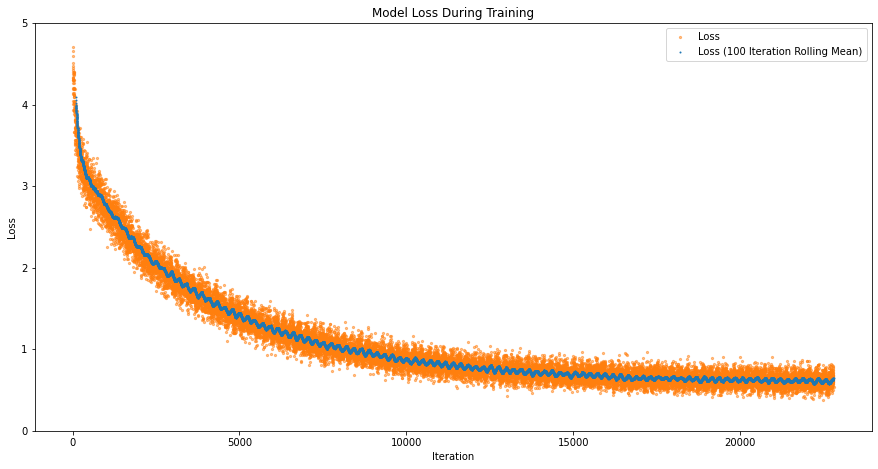

In [23]:
import pandas as pd

df = pd.DataFrame(L)
Lmean = df.rolling(100).mean().values

plt.figure(figsize=(15,7.5))
plt.title('Model Loss During Training')
plt.scatter(range(len(L)),L,5,alpha=.5,color='C1',label='Loss')
plt.scatter(range(len(Lmean)),Lmean,1,color='C0',label='Loss (100 Iteration Rolling Mean)')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.ylim([0,5])
plt.legend()
plt.show()


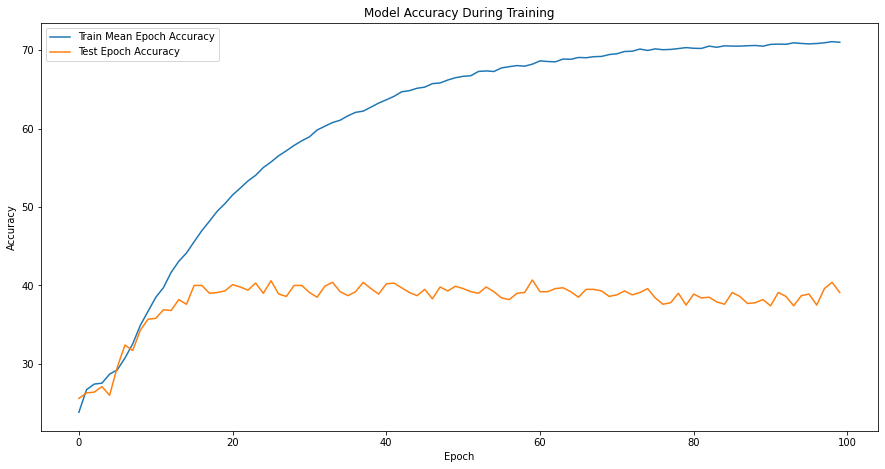

In [24]:
plt.figure(figsize=(15,7.5))
plt.title('Model Accuracy During Training')
plt.plot([tmea*100 for tmea in train_mean_epoch_accuracy],label='Train Mean Epoch Accuracy')
plt.plot([tea*100 for tea in test_epoch_accuracy],label='Test Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [25]:
import pickle

LA = test_epoch_loss

file_name = 'Original_VGG'
variables_list = [L,LA,
                  train_mean_epoch_accuracy,test_epoch_accuracy,
                  final_train_accuracy,final_test_accuracy,
                  word2idx]

with open('/content/gdrive/My Drive/aidl/VQA2015_PreProcessed_Images/' + file_name + '.pkl','wb') as file:
  pickle.dump(variables_list,file)